# Project work 
## Balogh Nóra, gyulai László, Vargha Noémi

In this project we have implemented 2 dimensional Ising model with Monte-Carlo simulation. We aimed to train neural networks based on the simulation results. 
The main parts of our work:
1. Implementing Monte-Carlo simulation code for the Ising model
2. Generating training data
3. 

Feladatok:
1. training data generáló függvény

2. adat feldolgozás
  *   fejléc: size,h,k,M,E,[mátrix]
  *   kimenet: megnézni, hogy mit kér a háló (kép, vagy adatsor)
  *   labels/tareget:
      - 1. M, E
      - 2. K
      - 3. h
   * train_test_split
3. neurális háló

Ideas:

https://arxiv.org/pdf/1706.09779.pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from numpy.random import rand
from numpy.random import randint

In [2]:
import random

In [3]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# 1. Monte-Carlo simulation code for the Ising model


We used a square lattice od size LxL=10x10. Each cell in the square lattice has spin $\sigma_i=\pm 1$ which is initialized randomly. The Hamiltonian of the system is:

$$ H=-K\sum_{\langle i\mathrm{,}j \rangle} \sigma_i \sigma_J - h\sum_{i}\sigma_i$$
where the summation runs over the nearest neighbors, $K$ is coupling strength between the nearest neighbors and $h$ is the external field.

assiged each lattice cell a random spin of $\pm 1$ with the function below:

Parameters of the 2D Ising model: 
* hi: interaction with external field
* Kij: interactions between neighbours

In [4]:
def initialize(L):   
    ''' generates a random spin (+1 or -1) configuration for initial condition'''
    state = 2*np.random.randint(2, size=(L,L))-1
    return state #square lattice, cells filled randomly with +1 or -1

Magnetization is the average value of the spin. (Source: https://en.wikipedia.org/wiki/Ising_model). The energy of a configuration is calculated from the Hamiltonian.

In [5]:
def magnetization(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)/(config.shape[0]*config.shape[1])
    return mag

def Energy(config, h, K):
    '''Calculates energy of a given configuration'''
    energy = 0
    L=len(config)
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            energy-=h*S
            #neighbors with periodic boundary conditions
            neighbors = config[(i+1)%L, j] + config[i,(j+1)%L] + config[(i-1)%L, j] + config[i,(j-1)%L] 
            energy -= K*neighbors*S
    return energy

One Monte Carlo timestep consists of LxL elementary step in which a spin is chosen randomly and flipped according to the Metropolis probabilities. 

In each elementary step we randomly choose a lattice point with spin $s$. If the spin is flipped, the cost is $\Delta E=E_{flipped}-E_{original}$. From the Hamiltonian:

$$\Delta E= 2hs-2Ks\cdot nb$$

where $nb$ is the sum of the spins of the nearest neighbors of s. The function "mcmove" below calculates this cost and flips the spin if $\Delta E < 0$ and flips this spin with probability $p=\exp(\beta\cdot\Delta E)$ if $E>0$. ($\beta=\frac{1}{k_bT}$)

In [6]:
def mcmove(config, beta, h, K):
    '''Monte Carlo move using Metropolis algorithm '''
    L=len(config)
    for i in range(L):
        for j in range(L):
                a = np.random.randint(0, L)
                b = np.random.randint(0, L)
                s =  config[a, b]
                neighbors = config[(a+1)%L,b] + config[a,(b+1)%L] + config[(a-1)%L,b] + config[a,(b-1)%L]
                #cost=difference between energies
                cost = 2*h*s + 2*K*neighbors*s
                if cost < 0:
                    s *= -1
                elif np.random.rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config

Use Monte carlo step as: config=mcmove(config, beta, h, K)

# 2. Training data generation

## 2.1 Generation of lattices for energy and magnetization prediction

In [7]:
K=1
beta=0.2
L=10
h=5
timesteps = 500
iterations = 20
config_data=[]


for i in range(iterations):
    config=initialize(L)
    E,M=np.zeros(timesteps), np.zeros(timesteps)
    M0=np.zeros(timesteps)
    for t in range(timesteps):
        E[t]=Energy(config, h, K)
        M[t]=magnetization(config)
        row1 = [E[t]]+[M[t]]+list(config.flatten())
        config_data.append(row1)
        config=mcmove(config, beta, h, K)

In [8]:
len(config_data)

10000

We will store in a .csv file the following features of each generated lattice:
* energy
* magnetization
* config: the lattice configuration (array of +1, -1 values)

In [9]:
with open('training_data.csv', 'w+', newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(config_data)
writeFile.close()

## 2.2. Training data generation for coupling strength prediction 

In each iteration we use different coupling strength and step 

In [10]:
K=1
beta=0.2
L=10
h=5
timesteps = 10
iterations = 5000
config_data=[]

E,M=np.zeros(iterations), np.zeros(iterations)
#Klist=[j/1000 for j in range(iterations)]
for i in range(iterations):
    K=random.random()*2  # k is a random value between 0 and 2
    config=initialize(L)
    for t in range(timesteps):
        config=mcmove(config, beta, h, K)
    E[i]=Energy(config, h, K)
    M[i]=magnetization(config)
    row1 = [K]+[E[i]]+[M[i]]+list(config.flatten())
    config_data.append(row1)

In [187]:
len(config_data)

5000

In [188]:
with open('training_data2.csv', 'w+', newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(config_data)
writeFile.close()

# 3. Neural Network learns to calculate energy and magnetization

## 3.1. Loading the data

In [49]:
traindata = pd.read_csv("training_data.csv", names=["E"]+["M"]+[i for i in range(L*L)])

In [53]:
trainlabelsE=traindata["E"].values
trainlabelsM=traindata["M"].values

In [192]:
train_attrs=traindata.drop(columns=["E", "M"])

# 

# Loading the data

In [189]:
traindata2 = pd.read_csv("training_data2.csv", names=["K"]+["E"]+["M"]+[i for i in range(L*L)])

In [190]:
trainlabelsK=traindata2["K"].values

In [191]:
train_attrs2=traindata2.drop(columns=["K"])

In [91]:
max(trainlabelsM)

1.0

In [92]:
min(trainlabelsM)

-0.12

In [93]:
type(trainlabelsM)

numpy.ndarray

In [94]:
trainlabelsM

array([0.02, 0.52, 0.74, ..., 0.96, 0.92, 0.96])

In [95]:
trainlabelsM=(trainlabelsM-(-1))/(1-(-1))

In [96]:
trainlabelsM

array([0.51, 0.76, 0.87, ..., 0.98, 0.96, 0.98])

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(train_attrs, trainlabelsM, test_size=0.33, random_state=0)

In [98]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6700, 100), (6700,), (3300, 100), (3300,))

In [99]:
model = Sequential()
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(1, activation='relu'))

In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [120]:
history = model.fit(x=X_train, y=Y_train, batch_size=32, epochs=100, validation_data=(X_test, Y_test))

Train on 6700 samples, validate on 3300 samples
Epoch 1/100
6700/6700 [==============================] - 0s 63us/step - loss: 9.1564e-04 - val_loss: 8.7617e-05
Epoch 2/100
6700/6700 [==============================] - 0s 24us/step - loss: 2.0900e-05 - val_loss: 6.7064e-05
Epoch 3/100
6700/6700 [==============================] - 0s 23us/step - loss: 2.1068e-05 - val_loss: 1.0166e-04
Epoch 4/100
6700/6700 [==============================] - 0s 22us/step - loss: 2.6724e-05 - val_loss: 6.3427e-05
Epoch 5/100
6700/6700 [==============================] - 0s 22us/step - loss: 1.2448e-05 - val_loss: 7.0155e-05
Epoch 6/100
6700/6700 [==============================] - 0s 23us/step - loss: 1.1392e-05 - val_loss: 5.7603e-05
Epoch 7/100
6700/6700 [==============================] - 0s 22us/step - loss: 4.1275e-05 - val_loss: 1.6797e-04
Epoch 8/100
6700/6700 [==============================] - 0s 22us/step - loss: 8.0378e-05 - val_loss: 6.5883e-05
Epoch 9/100
6700/6700 [==============================] -

In [121]:
preds = model.predict(X_test)
print('MSE : ', mean_squared_error(preds, Y_test))

MSE :  4.050433846230874e-05


Text(0, 0.5, 'count')

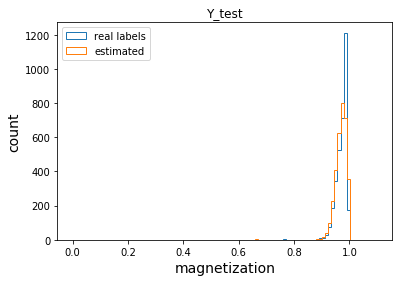

In [125]:
Y_hist = plt.hist(Y_test, 100, (0,1.1),histtype="step",alpha= 1.0)
plt.title("Y_test")
pred_hist = plt.hist(preds, 100, (0,1.1),histtype="step",alpha= 1.0)
plt.legend(["real labels", "estimated"], loc='upper left')
plt.xlabel("magnetization", fontsize = 14)
plt.ylabel("count",  fontsize = 14)

In [145]:
trainlabelsE=(trainlabelsE-min(trainlabelsE))/(max(trainlabelsE)-min(trainlabelsE))

In [153]:
max(trainlabelsE)

1.0

In [154]:
X_trainE, X_testE, Y_trainE, Y_testE = train_test_split(train_attrs, trainlabelsE, test_size=0.33, random_state=0)

In [160]:
model2 = Sequential()
model2.add(Dense(100, input_dim=100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(1, activation='relu'))

In [161]:
model2.compile(loss='mean_squared_error', optimizer='adam')

In [162]:
history = model2.fit(x=X_trainE, y=Y_trainE, batch_size=64, epochs=100, validation_data=(X_testE, Y_testE))

Train on 6700 samples, validate on 3300 samples
Epoch 1/100
6700/6700 [==============================] - 1s 82us/step - loss: 0.0094 - val_loss: 0.0090
Epoch 2/100
6700/6700 [==============================] - 0s 18us/step - loss: 0.0105 - val_loss: 0.0074
Epoch 3/100
6700/6700 [==============================] - 0s 17us/step - loss: 0.0095 - val_loss: 0.0089
Epoch 4/100
6700/6700 [==============================] - 0s 17us/step - loss: 0.0100 - val_loss: 0.0092
Epoch 5/100
6700/6700 [==============================] - 0s 16us/step - loss: 0.0097 - val_loss: 0.0089
Epoch 6/100
6700/6700 [==============================] - 0s 17us/step - loss: 0.0096 - val_loss: 0.0091
Epoch 7/100
6700/6700 [==============================] - 0s 17us/step - loss: 0.0097 - val_loss: 0.0089
Epoch 8/100
6700/6700 [==============================] - 0s 17us/step - loss: 0.0097 - val_loss: 0.0092
Epoch 9/100
6700/6700 [==============================] - 0s 15us/step - loss: 0.0098 - val_loss: 0.0090
Epoch 10/100
670

6700/6700 [==============================] - 0s 15us/step - loss: 1.0674e-04 - val_loss: 2.3021e-04
Epoch 75/100
6700/6700 [==============================] - 0s 15us/step - loss: 1.3226e-04 - val_loss: 3.0951e-04
Epoch 76/100
6700/6700 [==============================] - 0s 15us/step - loss: 9.3432e-05 - val_loss: 2.7257e-04
Epoch 77/100
6700/6700 [==============================] - 0s 15us/step - loss: 8.2300e-05 - val_loss: 2.3492e-04
Epoch 78/100
6700/6700 [==============================] - 0s 18us/step - loss: 6.7351e-05 - val_loss: 2.3420e-04
Epoch 79/100
6700/6700 [==============================] - 0s 18us/step - loss: 7.0664e-05 - val_loss: 2.2806e-04
Epoch 80/100
6700/6700 [==============================] - 0s 15us/step - loss: 7.1051e-05 - val_loss: 2.2800e-04
Epoch 81/100
6700/6700 [==============================] - 0s 15us/step - loss: 7.7821e-05 - val_loss: 2.3837e-04
Epoch 82/100
6700/6700 [==============================] - 0s 17us/step - loss: 7.6138e-05 - val_loss: 2.2694e

In [163]:
predsE = model2.predict(X_testE)
print('MSE : ', mean_squared_error(predsE, Y_testE))

MSE :  0.00018921456126465614


Text(0, 0.5, 'count')

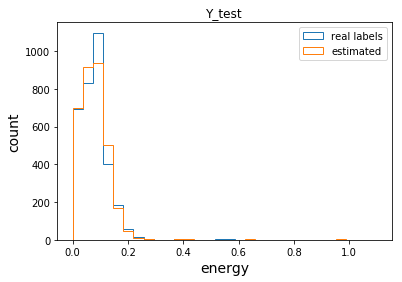

In [164]:
Y_hist = plt.hist(Y_testE, 30, (0,1.1),histtype="step",alpha= 1.0)
plt.title("Y_test")
pred_hist = plt.hist(predsE, 30, (0,1.1),histtype="step",alpha= 1.0)
plt.legend(["real labels", "estimated"])
plt.xlabel("energy", fontsize = 14)
plt.ylabel("count",  fontsize = 14)

# Defining a model